In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import datetime
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from keras.models import Model, load_model

In [3]:
def custom_print(text):
    now = datetime.datetime.now()
    print('Dia {} - {}:{}:{} - {}'.format(now.day, now.hour-3, now.minute, now.second, text))

In [4]:
all_xray_df = pd.read_csv('/kaggle/input/all-xray-df-original/all_xray_df.csv')

In [5]:
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/content/drive/My Drive/Colab Notebooks/ChestX-ray14/all_images_xray', '/kaggle/input/data', x))

In [6]:
# /kaggle/input/data/images_010/images/00022402_002.png
# /content/drive/My Drive/Colab Notebooks/ChestX-ray14/all_images_xray/
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_001', '/images_001/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_002', '/images_002/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_003', '/images_003/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_004', '/images_004/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_005', '/images_005/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_006', '/images_006/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_007', '/images_007/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_008', '/images_008/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_009', '/images_009/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_010', '/images_010/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_011', '/images_011/images', x))
all_xray_df['path'] = all_xray_df['path'].apply(lambda x: re.sub(r'/images_012', '/images_012/images', x))

In [7]:
# Substituir as labels com valor 'No Finding' em ''
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain

# Capturo apenas os valores únicos considerando os valores individuais de cada label separados entre si
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

# atualizo a variável all_labels excluindo os valores vazios
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [8]:
# Crio as colunas adicionais ao df
# cada coluna é uma doença descoberta no df all_labels
# e para cada coluna, se o valor for 1 da respectiva linha, significa que aquele exemplo
# tinha doença da respectiva coluna.
for c_label in all_labels:
    if len(c_label)>1: # deixar as labels 
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df_labels_detailed = all_xray_df[all_labels]

In [9]:
all_xray_df['disease_vector'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [10]:
all_xray_df['newLabel'] = all_xray_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
all_xray_df = all_xray_df[all_xray_df['Finding Labels'] != ""]

In [11]:
all_xray_df.to_csv('all_xray_df_path_kaggle.csv')

In [12]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 38819 validation 12940


In [13]:
IMG_SIZE = (250, 250)
core_idg = ImageDataGenerator(samplewise_center=True, 
  samplewise_std_normalization=True, 
  horizontal_flip = True, 
  vertical_flip = False, 
  height_shift_range= 0.05, 
  width_shift_range=0.1, 
  rotation_range=5, 
  shear_range = 0.1,
  fill_mode = 'reflect',
  zoom_range=0.15
)

In [14]:
def importar_imagens(train_df,valid_df):
  train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                              directory=None,
                              x_col = 'path',
                              y_col = 'newLabel', 
                              class_mode = 'categorical',
                              classes = all_labels,
                              target_size = IMG_SIZE,
                              color_mode = 'grayscale',
                              batch_size = 32,
  )

  valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                              directory=None,
                              x_col = 'path',
                              y_col = 'newLabel', 
                              class_mode = 'categorical',
                              classes = all_labels,
                              target_size = IMG_SIZE,
                              color_mode = 'grayscale',
                              batch_size = 256,
  )
  test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                              directory=None,
                              x_col = 'path',
                              y_col = 'newLabel', 
                              class_mode = 'categorical',
                              classes = all_labels,
                              target_size = IMG_SIZE,
                              color_mode = 'grayscale',
                              batch_size = 1024,
  ))

  return train_gen, valid_gen, test_X, test_Y

In [15]:
def importar_imagens_treinamento_apenas(train_df):
  train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                              directory=None,
                              x_col = 'path',
                              y_col = 'newLabel', 
                              class_mode = 'categorical',
                              classes = all_labels,
                              target_size = IMG_SIZE,
                              color_mode = 'grayscale',
                              batch_size = 32,
  )
  return train_gen

In [16]:
# Funcao que aumenta amostra
def upsampling(df, delta, rank_list, qtd_classes):
    '''
    df
    df_fitrado_com_apenas_a_label = dataframe
    delta do algoritmo de upsampling do artigo
    rank_list = DataFrane com o rank com as labels do melhor AUC (primeiro) e pior AUC (último)
    qtd_classes = inteiro
    '''
    try:
        rank_list_upsampling = rank_list.sort_values(by=[1],ascending=False)
    except:
        rank_list_upsampling = rank_list.sort_values(by=['1'],ascending=False)

    soma = 0
    df_original = df.copy()
    print("{:20} | {:9} | {:9} | {:9} | {:9} | {:9}".format("label","fator_k", "q_atualiz", "q_orig", "valor_cal", "qtd_final"))
    for i in range(qtd_classes):
        df_fitrado_com_apenas_a_label_original = df_original[df_original[rank_list_upsampling[0].iloc[i]]==1]
        df_fitrado_com_apenas_a_label_atualizado = df[df[rank_list_upsampling[0].iloc[i]]==1]
    
        pi_k = i+1
        qtd = ((pi_k - 1)/(qtd_classes - 1))*(delta-1) + 1
        qtd_atual_classe_original = df_fitrado_com_apenas_a_label_original.shape[0]
        qtd_atual_classe_atualizado = df_fitrado_com_apenas_a_label_atualizado.shape[0]

        diferenca = qtd_atual_classe_atualizado - qtd_atual_classe_original #Valor deveria ser maior ou igual a zero

        # Se a diferença entre o valor resultante das atualizações com o valor original for maior
        # que a o valor a ser adicionado pelo fator do artigo, então, não adiciono nada

        if (diferenca > int((qtd - 1) * qtd_atual_classe_original)):
            qtd_adicional = 0
        else:
            qtd_adicional = int((qtd - 1) * qtd_atual_classe_original) - diferenca

        print("{:20} | {:9.2f} | {:9.2f} | {:9.2f} | {:9.2f} | {:9.2f}".format(rank_list_upsampling[0].iloc[i], qtd, qtd_atual_classe_atualizado, qtd_atual_classe_original, int((qtd - 1) * qtd_atual_classe_atualizado), qtd_adicional))
        df_upsampled = resample(
            df_fitrado_com_apenas_a_label_atualizado,   # DataFrame com exemplos apenas daquela classe
            replace=True,                               # sample with replacement
            n_samples=qtd_adicional,                    # to match majority class
            random_state=1                              # reproducible results
        )
        # Adiciono os exemplos gerados na nbase original
        soma+=df_upsampled.shape[0]
        df = df.append(df_upsampled)
    return df

In [17]:
def VGG16_parameter(shape):
    base_model = tf.keras.applications.VGG16(input_shape =  shape, 
                                  include_top = False,
                                  weights=None,
                                  )
    base_model.trainable = False
    multi_disease_model = Sequential()
    multi_disease_model.add(base_model)
    multi_disease_model.add(Flatten())
    multi_disease_model.add(Dense(14,activation='sigmoid'))
    multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
    return multi_disease_model

In [18]:
# Baixar imagens
custom_print('Carregamento Imagens: início')
train_gen, valid_gen, test_X, test_Y = importar_imagens(train_df,valid_df)
custom_print('Carregamento Imagens: fim')

Dia 1 - -1:10:7 - Carregamento Imagens: início
Found 38819 validated image filenames belonging to 14 classes.
Found 12940 validated image filenames belonging to 14 classes.
Found 12940 validated image filenames belonging to 14 classes.
Dia 1 - -1:10:51 - Carregamento Imagens: fim


In [19]:
'''
Algoritmo inteiro numa função:
1 - input: train_gen, valid_gen, test_X, test_Y,ciclos,epocas
2 - output: modelo treinado depois de vários ciclos e épocas & último train_gen

'''

def rodar_todo_algoritmo(train_gen, valid_gen, test_X, test_Y, train_df, ciclos, epocas, versao_modelo, epoca_inicial = 0, path_modelo_rodado = None, ciclo=0):
    if (path_modelo_rodado != None):
        multi_disease_model = load_model(path_modelo_rodado)
    else:
        multi_disease_model = VGG16_parameter((250,250,1))
    
#     for ciclo in range(ciclos):
    while (ciclo < ciclos):
        print('##########################################')
        print('##########################################')
        custom_print('Ciclo {} iniciado'.format(ciclo))
        nome_modelo_path = "{}_ciclo_{}_epocas_{}_versao_modelo_VGG_16.hdf5".format(ciclo,epocas,versao_modelo)
        checkpoint = ModelCheckpoint(nome_modelo_path, monitor='val_loss', verbose=1, mode='min', save_best_only = True, save_weights_only = False)
        early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
        callbacks_list = [checkpoint, early]
        
        custom_print('Treinamento iniciado')
        if (ciclo == 0 & epoca_inicial > 0):            
            multi_disease_model.fit_generator(train_gen,
                                              steps_per_epoch = train_df.shape[0] //train_gen.batch_size,
                                              validation_data =  valid_gen, 
                                              epochs = epocas, 
                                              callbacks = callbacks_list,
                                              initial_epoch = epoca_inicial)
        else:
            multi_disease_model.fit_generator(train_gen,
                                              steps_per_epoch = train_df.shape[0] //train_gen.batch_size,
                                              validation_data =  valid_gen, 
                                              epochs = epocas, 
                                              callbacks = callbacks_list)
            
        custom_print('Treinamento terminado')

        # preve com a base de testes e gera a curva ROC
        pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

        fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
        rank_list = []
        for (idx, c_label) in enumerate(all_labels):
            fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
            rank_list.append([c_label,auc(fpr, tpr)])
        rank_list = pd.DataFrame(rank_list)
        c_ax.legend()
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        fig.savefig('trained_net.png')
        
        path_rank_list = '{}_ciclo_{}_epocas_rank_list_VGG_16.csv'.format(ciclo,epocas)
        rank_list.to_csv(path_rank_list)
        
        # upsampling da base de treinamento para depois testar com X epocas novamente
        train_df = upsampling(train_df,2,rank_list,14)
        
        # misturo os dados
        train_df = train_df.sample(frac=1,random_state=1).reset_index(drop=True)
        
        train_df.shape

        path_rank_list = '{}_ciclo_{}_epocas_rank_list_VGG_16.csv'.format(ciclo,epocas)
        rank_list.to_csv(path_rank_list)

        # Baixar imagens após primeiro upsampling e depois de 5 épocas
        custom_print('Carregamento Imagens: início')
        train_gen = importar_imagens_treinamento_apenas(train_df)
        custom_print('Carregamento Imagens: fim')
        ciclo+=1
    return multi_disease_model, train_gen

In [20]:
# Caso eu tenha os modelos .hdf5 salvos, porém, o Kaggle interrompeu a sessão do notebook
# Preciso dar commit manualmente no notebook apertando o botão Save Version acima/direita
def recuperar_train_gen_para_continuar_ciclo(ciclo,epocas,versao_modelo,train_df):
    for i in range(ciclo):
        nome_modelo_path = "/kaggle/input/modelos-de-5-epocas-2-ciclos/{}_ciclo_{}_epocas_{}_versao_modelo_VGG_16.hdf5".format(i,epocas,versao_modelo)
        multi_disease_model = load_model(nome_modelo_path)

        # preve com a base de testes e gera a curva ROC
        pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

        rank_list = []
        for (idx, c_label) in enumerate(all_labels):
            fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
            rank_list.append([c_label,auc(fpr, tpr)])
        rank_list = pd.DataFrame(rank_list)
        train_df = upsampling(train_df,2,rank_list,14)
        # misturo os dados
        train_df = train_df.sample(frac=1,random_state=1).reset_index(drop=True)        
    # Baixar imagens após primeiro upsampling e depois de 5 épocas
    custom_print('Carregamento Imagens: início')
    train_gen = importar_imagens_treinamento_apenas(train_df)
    custom_print('Carregamento Imagens: fim')
    return train_gen, train_df

##########################################
##########################################
Dia 1 - -1:10:54 - Ciclo 0 iniciado
Dia 1 - -1:10:54 - Treinamento iniciado
Epoch 1/5
1213/1213 [==============================] - ETA: 0s - loss: 0.3154 - binary_accuracy: 0.8876 - mae: 0.1937
Epoch 00001: val_loss improved from inf to 0.30166, saving model to 0_ciclo_5_epocas_1_versao_modelo_VGG_16.hdf5
1213/1213 [==============================] - 1353s 1s/step - loss: 0.3154 - binary_accuracy: 0.8876 - mae: 0.1937 - val_loss: 0.3017 - val_binary_accuracy: 0.8881 - val_mae: 0.1762
Epoch 2/5
1213/1213 [==============================] - ETA: 0s - loss: 0.3005 - binary_accuracy: 0.8879 - mae: 0.1769
Epoch 00002: val_loss improved from 0.30166 to 0.29983, saving model to 0_ciclo_5_epocas_1_versao_modelo_VGG_16.hdf5
1213/1213 [==============================] - 1422s 1s/step - loss: 0.3005 - binary_accuracy: 0.8879 - mae: 0.1769 - val_loss: 0.2998 - val_binary_accuracy: 0.8883 - val_mae: 0.1762
Epoch 3/5


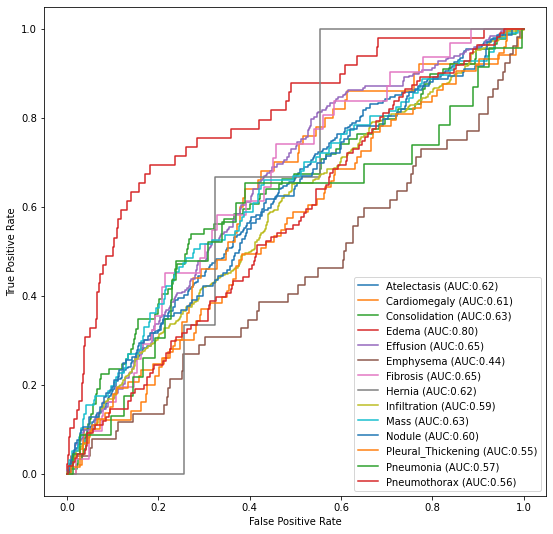

In [21]:
multi_disease_model_novo , train_gen_novo = rodar_todo_algoritmo(train_gen, valid_gen, test_X, test_Y, train_df, ciclos=1,epocas=5,versao_modelo=1)